# Reconociendo señales de tráfico 
 
El objetivo de este proyecto es construir un modelo capaz de determinar el tipo de señal de tráfico que se muestra en una imagen capturada en diferentes condiciones de la vida real y que muestre obstrucciones, mala iluminación o incluso que la señal esté lejos de la cámara. Le proporcionamos imágenes etiquetadas ya divididas en tres archivos (entrenamiento / validación / prueba) y una lista predefinida de signos para reconocer.

In [2]:
import os

dataroot = "datos/dataroot/"
os.makedirs(dataroot, exist_ok=True)  


!curl -o datos/dataroot/data_1.zip https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!curl -o datos/dataroot/data_2.zip https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip
!curl -o datos/dataroot/data_3.zip https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 30.5M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 52 30.5M   52 16.0M    0     0  6908k      0  0:00:04  0:00:02  0:00:02 6915k
 88 30.5M   88 27.1M    0     0  8216k      0  0:00:03  0:00:03 --:--:-- 8222k
100 30.5M  100 30.5M    0     0  8465k      0  0:00:03  0:00:03 --:--:-- 8470k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  9.8M    0 15472    0     0  18754      0  0:09:08 --:--:--  0:09:08 18799
100  9.8M  100  9.8M    0     0  8921k      0  0:0

In [3]:
# Descomprimir 
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [1]:
# Cargar nombres de las señales 
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()

In [33]:
# cargar las imágenes 
import pickle
signimages = pickle.load( open( "datos/dataroot/RTS/train.p", "rb" ) )
signimages_valid = pickle.load( open( "datos/dataroot/RTS/valid.p", "rb" ) )
signimages_test = pickle.load( open( "datos/dataroot/RTS/test.p", "rb" ) )

The image shows a Wild animals crossing sign


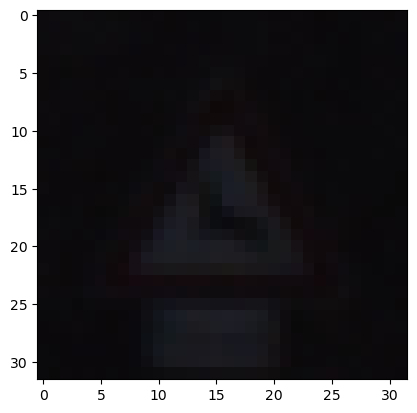

In [3]:
# ver imagen 
import matplotlib.pyplot as plt
import numpy as np
import cv2

inx =60
plt.imshow(signimages_valid['features'][inx])
print("The image shows a {} sign".format(signnames[signimages_valid['labels'][inx]]))

# Feature extraction

In [14]:
import pandas as pd
import cv2
import numpy as np
from skimage import feature, color
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops

In [11]:
def extract_features_from_image(img):
    img_bgr = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)

    #Matiz (H) - Saturacion (S) - Brillo (V) 
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h_mean = np.mean(hsv[:,:,0])
    h_std = np.std(hsv[:,:,0])

    s_mean = np.mean(hsv[:,:,1])
    s_std = np.std(hsv[:,:,1])

    v_mean = np.mean(hsv[:,:,2])
    v_std = np.std(hsv[:,:,2])

    #GLCM (Contraste - Energia - Homogeneidad)

    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    contrast = graycoprops(glcm,'contrast').mean()
    energy = graycoprops(glcm,'energy').mean()
    homogeneity = graycoprops(glcm,'homogeneity').mean()
    
    #Textura: HOG
    hog_features = feature.hog(gray, orientations=6, pixels_per_cell=(16, 16),
                              cells_per_block=(2, 2), block_norm='L2-Hys')
    

    features = {'h_mean': h_mean,
                'h_std':h_std,
                's_mean':s_mean,
                's_std':s_std,
                'v_mean': v_mean,
                'v_std': v_std,
                'contrast': contrast,
                'energy': energy,
                'homogeneity': homogeneity,    
            }
    
    for i in range(len(hog_features)):
        features[f'hog_{i}'] = hog_features[i]
    return features


## Function

### Train

In [32]:
features_list = []
labels_list = []
for i in tqdm(range(len(signimages['features']))):
    img = signimages['features'][i]
    label = signimages['labels'][i]

    features = extract_features_from_image(img)

    features_list.append(features)
    labels_list.append(label)

# Creamos DataFrame con nombres de columnas
df_features = pd.DataFrame(features_list)
df_features['label'] = labels_list




  0%|          | 0/34799 [00:00<?, ?it/s]

100%|██████████| 34799/34799 [08:30<00:00, 68.17it/s]


### Valid

In [35]:
features_list = []
labels_list = []
for i in tqdm(range(len(signimages_valid['features']))):
    img = signimages_valid['features'][i]
    label = signimages_valid['labels'][i]

    features = extract_features_from_image(img)

    features_list.append(features)
    labels_list.append(label)

# Creamos DataFrame con nombres de columnas
df_features_valid = pd.DataFrame(features_list)
df_features_valid['label'] = labels_list

100%|██████████| 4410/4410 [01:03<00:00, 69.83it/s]


### Test

In [36]:
features_list = []
labels_list = []
for i in tqdm(range(len(signimages_test['features']))):
    img = signimages_test['features'][i]
    label = signimages_test['labels'][i]

    features = extract_features_from_image(img)

    features_list.append(features)
    labels_list.append(label)

# Creamos DataFrame con nombres de columnas
df_features_test = pd.DataFrame(features_list)
df_features_test['label'] = labels_list

100%|██████████| 12630/12630 [02:58<00:00, 70.60it/s]


## Normalización y reducción de dimensionalidad

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_features.drop(columns='label')
y = df_features['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_valid_scaled = scaler.transform(df_features_valid.drop(columns='label'))
X_test_scaled = scaler.transform(df_features_test.drop(columns='label'))



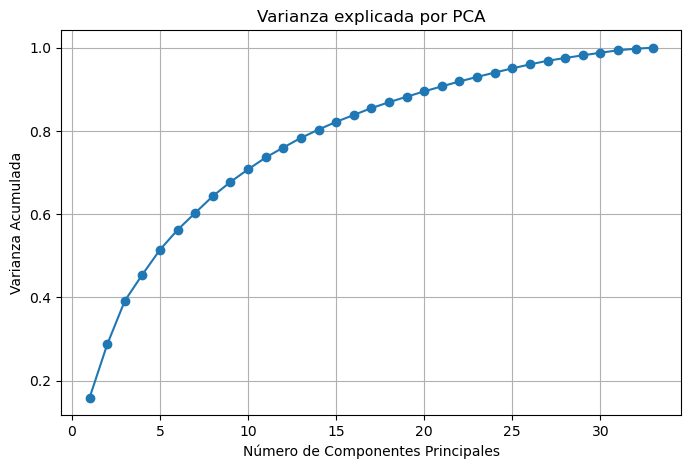

In [40]:
# 3. Aplicar PCA
pca = PCA(n_components=None)  # Podés elegir n_components=2 si querés solo 2 componentes
X_pca = pca.fit_transform(X_scaled)

# 4. Ver cuánta varianza explica cada componente
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza explicada por PCA')
plt.grid(True)
plt.show()

In [47]:
pca = PCA(n_components=15)  
X_pca = pca.fit_transform(X_scaled)
y = df_features['label']
X_valid_pca = pca.transform(X_valid_scaled)
y_valid = df_features_valid['label']
X_test_pca = pca.transform(X_test_scaled)
y_test = df_features_test['label']

## Training

In [49]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score,f1_score,precision_score


for k in [1,3,5,7,9,12,15]:
  
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_pca,y)

  y_pred = knn.predict(X_valid_pca)
  print("Para un k: ",k)
  print("Accuracy:", accuracy_score(y_valid, y_pred))
  print("F1 Score:", f1_score(y_valid, y_pred,average = 'weighted'))
  print("Precision: ",precision_score(y_valid,y_pred,average='weighted'))
  print("###")

Para un k:  1
Accuracy: 0.33129251700680273
F1 Score: 0.32912492560768886
Precision:  0.3389681267240226
###
Para un k:  3
Accuracy: 0.33945578231292517
F1 Score: 0.3395863286506534
Precision:  0.3678977805457569
###
Para un k:  5
Accuracy: 0.35011337868480724
F1 Score: 0.34661383104535587
Precision:  0.3670350467370087
###
Para un k:  7
Accuracy: 0.34467120181405897
F1 Score: 0.3425692412026968
Precision:  0.3617552279841259
###
Para un k:  9
Accuracy: 0.35034013605442177
F1 Score: 0.34640742103481825
Precision:  0.36341194618673
###
Para un k:  12
Accuracy: 0.3471655328798186
F1 Score: 0.3430114503081295
Precision:  0.3618520272175761
###
Para un k:  15
Accuracy: 0.3517006802721088
F1 Score: 0.34862991337080007
Precision:  0.3687940890480423
###


## Matriz de correlación

In [53]:
df_features

,h_mean,h_std,s_mean,s_std,v_mean,v_std,contrast,energy,homogeneity,hog_0,...,hog_15,hog_16,hog_17,hog_18,hog_19,hog_20,hog_21,hog_22,hog_23,label
0,35.579102,50.001695,46.147461,28.176355,48.215820,24.433010,94.136186,0.099731,0.338756,0.250256,...,0.198929,0.185122,0.250256,0.250256,0.250256,0.250256,0.174298,0.031528,0.144299,41
1,28.720703,42.772245,44.888672,25.414365,46.191406,24.024696,90.430842,0.111040,0.358548,0.252394,...,0.252394,0.162581,0.252394,0.252394,0.252394,0.252394,0.134684,0.047218,0.052971,41
2,29.080078,42.917179,47.946289,28.487286,47.138672,23.846111,94.523104,0.101877,0.346621,0.252647,...,0.252647,0.211060,0.242971,0.252647,0.252647,0.252647,0.111863,0.017319,0.043375,41
3,29.175781,42.209235,47.129883,28.567589,47.454102,23.872297,93.668965,0.097487,0.345930,0.252744,...,0.252744,0.182663,0.252744,0.252744,0.252744,0.252744,0.135605,0.016988,0.060941,41
4,27.336914,39.059909,49.238281,27.332156,47.242188,23.937947,101.401689,0.095365,0.349354,0.248606,...,0.248606,0.191885,0.248606,0.248606,0.248606,0.248606,0.095471,0.018206,0.090044,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34794,119.816406,34.479748,60.124023,27.558341,49.656250,30.460095,448.450337,0.045500,0.145746,0.297095,...,0.101946,0.057103,0.191642,0.207153,0.113381,0.118145,0.168330,0.297095,0.297095,25
34795,119.257812,37.460212,54.708984,26.610862,53.014648,38.079722,496.715588,0.045694,0.146740,0.295670,...,0.110855,0.030692,0.035749,0.208749,0.068252,0.103236,0.212740,0.295670,0.295670,25
34796,122.192383,35.668382,53.800781,26.582701,57.145508,43.547246,648.942744,0.044864,0.145542,0.305999,...,0.069083,0.031698,0.048959,0.174434,0.123104,0.142157,0.210073,0.307585,0.307585,25
34797,123.304688,33.690615,53.402344,28.627597,54.860352,43.791666,623.304240,0.047537,0.163633,0.305223,...,0.084973,0.016537,0.033928,0.137062,0.093492,0.112556,0.166519,0.305223,0.305223,25


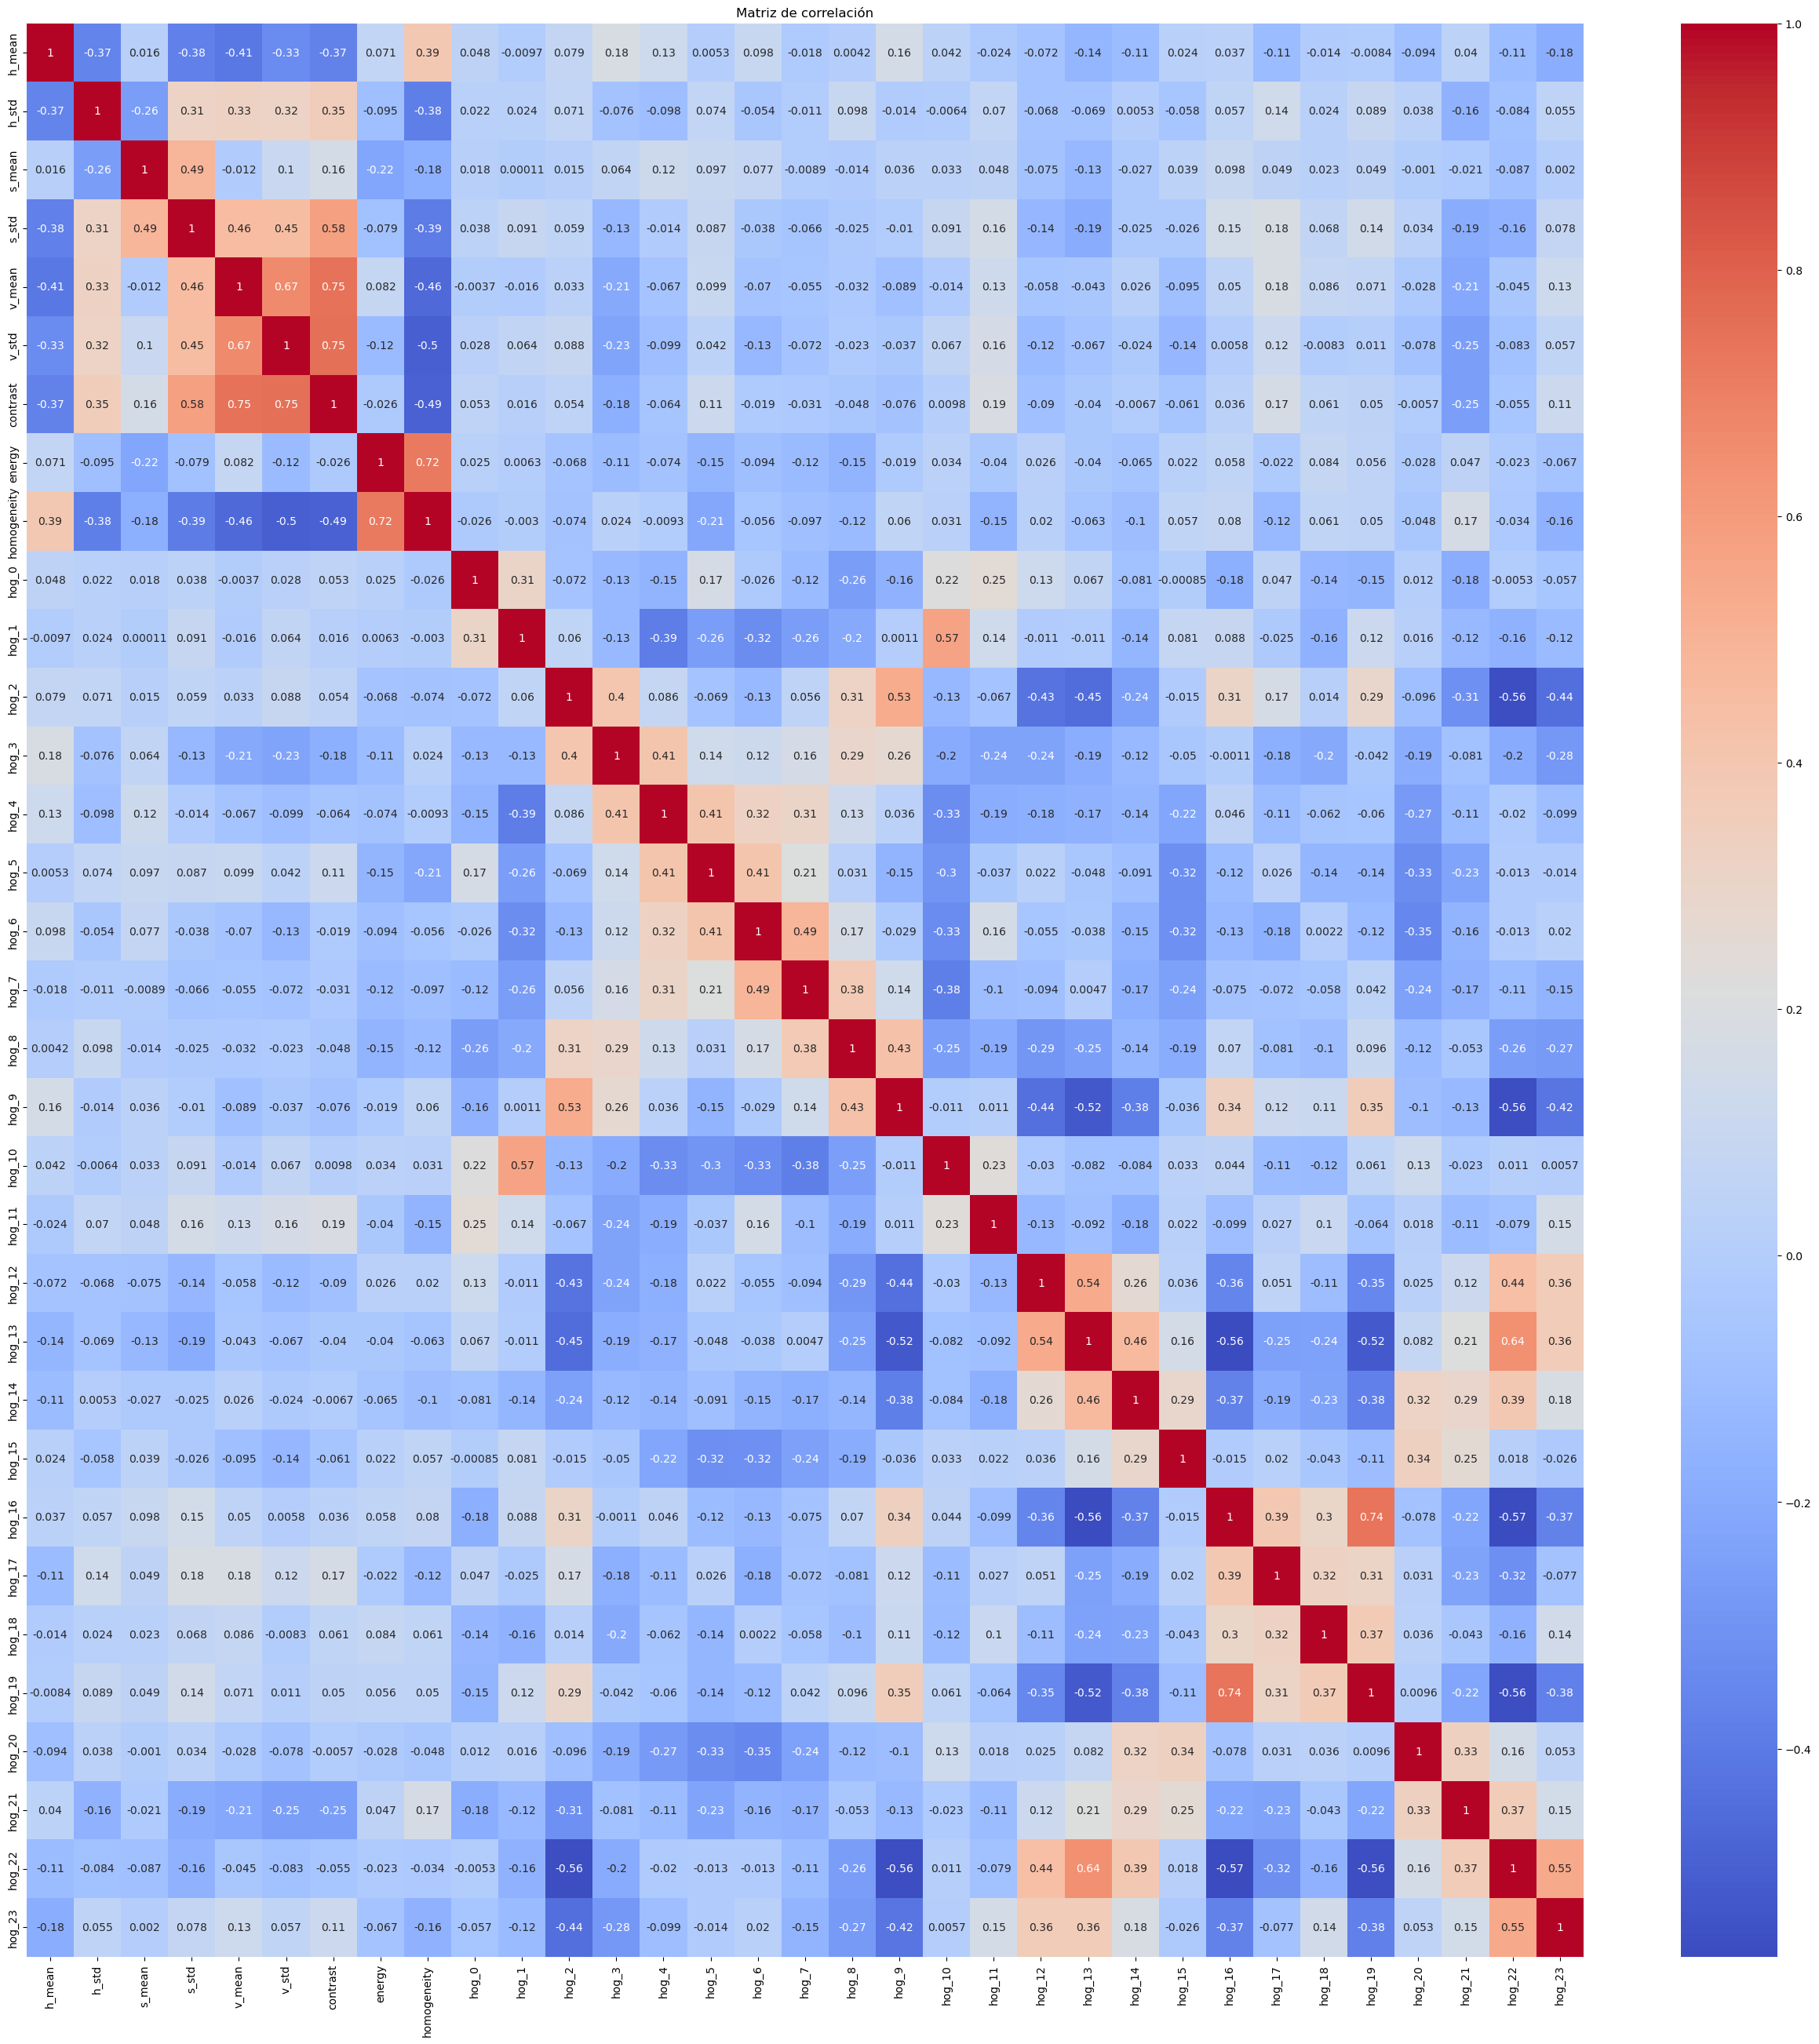

In [52]:
import seaborn as sns

df1 = df_features.drop(columns='label')
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(32, 32))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()